In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr 
import math
from pylab import *

#### Read in TSV Data.  Format Salary field properly.

In [2]:
df_total = pd.read_csv('test_player_dataframe_1.txt',sep='\t')

df_total.Salary = df_total['Salary'].str.replace('$','')
df_total.Salary = df_total['Salary'].str.replace(',','')
df_total.Salary = df_total['Salary'].astype(float)

### Create Weighted Average Dataframe 
Create a dataframe that represents the weighted averages of each player's seasons on their rookie contract.  This will give us a representation of their body of work up until the point of their new contract.  Store the player's new non-rookie contract in the same row so we can see the relationships between the weighted averages of statistics and their new contract.

In [3]:
players = df_total['Player'].unique()

list_of_rookie_contract_data = []
list_of_first_contract_data = []
list_of_columns_to_average = ['Age','G','GS','MP_x','FG','FGA',
 'FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB',
 'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','MP_y','PER','TS%','3PAr',
 'FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS','DWS',
 'WS','WS/48','OBPM','DBPM','BPM','VORP']
list_of_averaged_rows = []

#For each player in original dataset, create a Rookie table of just his first 4 seasons
#Also create a Contract datatable of his first year with the new contract
for player in players:
    df_player = df_total[df_total['Player'] == player]
    df_player_rookie = df_player.iloc[0:3]
    df_player_contract = df_player.iloc[4:5]
#Append these individual dataframes to separate lists, they will later be concatendated into one larger dataframe    
    list_of_rookie_contract_data.append(df_player_rookie)
    list_of_first_contract_data.append(df_player_contract)

#############################################################################################
# Create a dataframe of the weight averages of numerical columns during players first 4 seasons
#############################################################################################    
    weight_array =[]
    total_minutes = 0
    for index, row in df_player_rookie.iterrows():
        #The weight used will be based off minutes played for each seasons
        weight = row.MP_x * row.G
        #Make an array of the weights for each season
        weight_array.append(weight)
        total_minutes = weight + total_minutes
    #If they didn't play in a given season, skip    
    if total_minutes == 0:
        continue
    #Normalize the weight array    
    weight_array[:] = [x / total_minutes for x in weight_array]

    ##Iterate through the new Rookie dataframe, apply weighted average for numerical columns
    ##If column is Salary, grab it from the Contract table
    ##If column is non-numeric, just add a placeholder value to the row
    new_row = []
    if len(df_player) <5:
        continue
    for column in df_player_rookie.columns:        
        if column in list_of_columns_to_average:
            new_row.append(np.dot(weight_array,df_player_rookie[column]))
        elif column == 'Salary':
            new_row.append(df_player.iloc[4:5]['Salary'].values[0])
        elif column == 'Salary%':
            new_row.append(df_player.iloc[4:5]['Salary%'].values[0])    
        else:
            var = df_player_rookie.iloc[:-2][column].values[0]
            new_row.append(var)
    list_of_averaged_rows.append(new_row)
list_of_averaged_rows = pd.Series(list_of_averaged_rows)

##Make the larger rookie and contract dataframes
df_rookie_total = pd.concat(list_of_rookie_contract_data)
df_contract_total = pd.concat(list_of_first_contract_data)
##Make the larger rookie_averages dataframe
df_rookie_averages = pd.DataFrame.from_items(zip(list_of_averaged_rows.index,list_of_averaged_rows.values)).T
df_rookie_averages.columns = list(df_total.columns.values)

In [68]:
from sklearn.linear_model import LinearRegression
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','TOV']]
print(len(df_rookie_averages['PTS']))
print(len(df_rookie_averages['Salary%']))
lm = LinearRegression()

#lm.fit(X=df_rookie_averages['PTS'].to_frame(),y=df_rookie_averages['Salary%'].to_frame())
lm.fit(X=independent_vars,y=df_rookie_averages['Salary%'].to_frame())

lm.get_params(deep=True)
#print(lm.score(X=df_rookie_averages['PTS'].to_frame(),y=df_rookie_averages['Salary%'].to_frame()))
print(lm.score(X=independent_vars,y=df_rookie_averages['Salary%'].to_frame()))
print(lm.coef_)
print(lm.intercept_)

766
766
0.620060476423
[[ 0.00843731  0.0093365   0.00738141  0.02882312 -0.01193533]]
[-0.02944301]


In [88]:
import statsmodels.api as sm

target = pd.DataFrame(df_rookie_averages['Salary%'])
independent_vars = df_rookie_averages.loc[:,['PTS','AST','TRB','BLK','DWS','Age']]
independent_vars.astype(float)
independent_vars.dropna(inplace=True)
independent_vars.describe()

model = sm.OLS(list(target['Salary%'].astype(float)),independent_vars.astype(float)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     738.3
Date:                Mon, 28 May 2018   Prob (F-statistic):          4.67e-313
Time:                        17:40:50   Log-Likelihood:                 1282.2
No. Observations:                 766   AIC:                            -2552.
Df Residuals:                     760   BIC:                            -2525.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
PTS            0.0073      0.001     12.704      0.000         0.006     0.008
AST            0.0036      0.001      2.417      0.016         0.001     0.007
TRB            0.0034      0.001      2.421      0.016         0.001     0.006
BLK            0.0196      0.005      4.151      0.000         0.010     0.029
DWS            0.0175      0.003      6.501      0.000         0.012     0.023
Age           -0.0013      0.000     -8.153      0.000        -0.002    -0.001
==============================================================================
Omnibus:                       69.571   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.619
Skew:                           0.403   Prob(JB):                     1.68e-49
Kurtosis:                       5.527   Cond. No.                         73.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

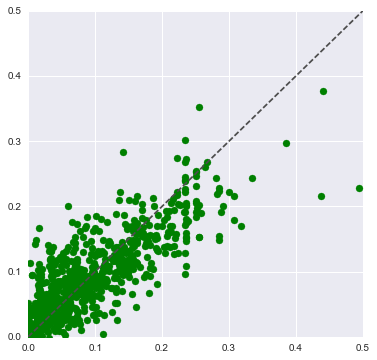

In [87]:
f, ax = plt.subplots(figsize=(6, 6))

plt.scatter(target, model.predict(), color="g", label="Linear")

ax.plot([0, 0.5], [0, 0.5], ls="--", c=".3")
ax.set(xlim=(0,0.5), ylim=(0,0.5))
plt.show()